# Comparison of Metaheuristic Algorithms (SA, TS, GA)

As illustrated in the lectures, simulated annealing is a probablistic technique used for finding an approximate solution to an optimization problem.  In this exercise you will check your understanding by implementing [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) to solve the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) (TSP) between US state capitals.  Briefly, the TSP is an optimization problem that seeks to find the shortest path passing through every city exactly once.  In our example the TSP path is defined to start and end in the same city (so the path is a closed loop).

![Simulated Annealing](https://upload.wikimedia.org/wikipedia/commons/d/d5/Hill_Climbing_with_Simulated_Annealing.gif)

# 1. Setup

In [ ]:
%pip install numpy scipy tqdm matplotlib

In [ ]:
!wget https://raw.githubusercontent.com/kspurlock/cse620-code/refs/heads/main/resource/capitals.json
!wget https://raw.githubusercontent.com/kspurlock/cse620-code/refs/heads/main/resource/map.png

In [5]:
import json
import copy
import numpy as np
from scipy import stats
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from typing import Sequence, Tuple
import sys

%matplotlib inline

In [106]:
"""Read input data and define helper functions for visualization."""

# Map services and data available from U.S. Geological Survey, National Geospatial Program.
# Please go to http://www.usgs.gov/visual-id/credit_usgs.html for further information
map_bg = mpimg.imread("map.png")  # US States & Capitals map

# List of 30 US state capitals and corresponding coordinates on the map
with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
capitals_list = list(capitals.items())

def show_path(path, starting_city, w=12, h=8):
  x, y = list(zip(*path))
  _, (x0, y0) = starting_city
  plt.imshow(map_bg)
  plt.scatter(x0, y0, marker="*", s=300, color="red", zorder=1) # Plot start city
  plt.scatter(x, y, s=20, color="red", zorder=1) # Plot other cities

  for i in range(len(x)-1):
    plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width=8, length_includes_head=True, color="tab:blue", zorder=0)
  plt.arrow(x[-1], y[-1], x[0] - x[-1], y[0] - y[-1], head_width=8, length_includes_head=True, color="tab:blue", zorder=0)

  plt.axis("off")
  fig = plt.gcf()
  fig.set_size_inches([w, h])


## 1.1 Representing the Problem

In order to use simulated annealing we need to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of simulated annealing and other optimization techniques.  Since the TSP deals with a close loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid.  The _state_ will then consist of an ordered sequence (a list) of the cities; the path is defined as the sequence generated by traveling from each city in the list to the next in order.

In [10]:
def L2_dist(x: Tuple[float, float], y: Tuple[float, float]) -> float:
    return ((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2) ** 0.5

class TravelingSalesmanProblem():
    """Representation of a traveling salesman optimization problem.  The goal
    is to find the shortest path that visits every city in a closed loop path.

    Students should only need to implement or modify the successors() and
    get_values() methods.

    Parameters
    ----------
    cities : list
        A list of cities specified by a tuple containing the name and the x, y
        location of the city on a grid. e.g., ("Atlanta", (585.6, 376.8))

    Attributes
    ----------
    names
    coords
    path : list
        The current path between cities as specified by the order of the city
        tuples in the list.
    """

    def __init__(self, cities, dist_measure=L2_dist):
        self.path = copy.deepcopy(cities)
        self.dist_measure = dist_measure

    def copy(self):
        """Return a copy of the current path state."""
        new_tsp = TravelingSalesmanProblem(self.path)
        return new_tsp

    @property
    def names(self) -> Sequence[str]:
        """Strip and return only the city name from each element of the
        path list. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> ["Atlanta", ...]
        """
        names, _ = zip(*self.path)
        return names

    @property
    def coords(self) -> Sequence[Tuple[float, float]]:
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*self.path)
        return coords

    def get_neighbors(self) -> Sequence["TravelingSalesmanProblem"]:
        """Return a list of states in the neighborhood of the current state by
        switching the order in which any adjacent pair of cities is visited.

        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [A, B, D, C], [A, C, B, D], [B, A, C, D],
        and [D, B, C, A]. (The order of successors does not matter.)

        In general, a path of N cities will have N neighbors (note that path wraps
        around the end of the list between the first and last cities).

        Returns
        -------
        list<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """
        neighbors = []
        for i in range(len(self.path) - 1):
            new_path = self.copy()
            new_path.path[i], new_path.path[i + 1] = (
                new_path.path[i + 1],
                new_path.path[i],
            )  # Swap two non-adjacent edges
            neighbors.append(new_path)

        last_path = self.copy()
        last_path.path[0], last_path.path[-1] = last_path.path[-1], last_path.path[0]
        neighbors.append(last_path)

        return neighbors

    def evaluate(self) -> float:
        """Calculate the total length of the closed-circuit path of the current
        state by summing the distance between every pair of adjacent cities.

        Returns
        -------
        float
            A floating point value with the total cost of the path given by visiting
            the cities in the order according to the self.cities list

        Notes
        -----
            (1) Remember to include the edge from the last city back to the
            first city

            (2) Remember to multiply the path length by -1 so that simulated
            annealing finds the shortest path
        """

        length = 0
        coords = self.coords
        for i in range(len(coords) - 1):
            length += np.abs(self.dist_measure(coords[i], coords[i + 1]))

        length += np.abs(
            self.dist_measure(coords[0], coords[-1])
        )  # Return to the initial city
        return length

    def __hash__(self):
        """
        Returns
        -------
        int
            Signed integer value representign hash of the path name string
        """

        return hash("".join(self.names))

In [11]:
def generate_TSP(num_cities, random_state=None):
    """Method to randomly generate the cities for a TSP problem instance"""
    rand_gen = np.random.default_rng(random_state)

    capitals_idx = rand_gen.choice(
        list(range(0, len(capitals_list))), size=(num_cities,), replace=False
    )

    return np.array(capitals_list, dtype="object")[capitals_idx].tolist()

## 1.2 Testing TravelingSalesmanProblem
The following tests should validate the class constructor and functionality of the `neighborhood()` and `evaluate()` methods.

In [12]:
# Construct an instance of the TravelingSalesmanProblem
test_cities = [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
tsp = TravelingSalesmanProblem(test_cities)
assert(tsp.path == test_cities)

In [14]:
for path in list(tsp.get_neighbors()):
    print(path.names)
    print(path.coords)
    print("Cost: %.2f" % path.evaluate(), "\n")

('SF', 'DC', 'PHX', 'LA')
((0, 0), (11, 1), (2, -3), (0, -4))
Cost: 27.13 

('DC', 'PHX', 'SF', 'LA')
((11, 1), (2, -3), (0, 0), (0, -4))
Cost: 29.54 

('DC', 'SF', 'LA', 'PHX')
((11, 1), (0, 0), (0, -4), (2, -3))
Cost: 27.13 

('LA', 'SF', 'PHX', 'DC')
((0, -4), (0, 0), (2, -3), (11, 1))
Cost: 29.54 



# 2. Simulated Annealing

The main loop of simulated annealing repeatedly generates successors in the neighborhood of the current state and considers moving there according to an acceptance probability distribution parameterized by a cooling schedule.  See the [simulated-annealing function](https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md) pseudocode from the AIMA textbook online at github.

In [21]:
def simulated_annealing(problem, cooling_schedule, stop_temp=1e-5, max_iter=np.inf, random_state=None, verbose=True):
    """The simulated annealing algorithm, a version of stochastic hill climbing
    where some downhill moves are allowed. Downhill moves are accepted readily
    early in the annealing schedule and then less often as time goes on. The
    schedule input determines the value of the temperature T as a function of
    time.

    Parameters
    ----------
    problem : Problem
        An optimization problem, already initialized to a random starting state.
        The Problem class interface must implement a callable method
        "get_neighbors()" which returns states in the neighborhood of the current
        state, and a callable function "evaluate()" which returns a fitness
        score for the state. (See the `TravelingSalesmanProblem` class for more details.)

    cooling_schedule : Schedule
        Instance of Schedule class initialized containing starting temp, alpha, and specified
        cooling method to use.

    stop_criteria : float
        Threshold for the temperature to determine when to stop the search.

    max_iter : int
        Specifies part of the stopping critiera, by default there is no limit placed on
        maximum iterations.

    random_state : int
        The seed for the pseudorandom number generator. Passing "None" or no argument
        will result in wholely random behaviour each run. Passing any other integer value
        will produce the same behaviour and final convergence each run.

    verbose : bool
        Specifies whether or not to produce output while running

    Returns
    -------
    Problem
        An approximate *best* found solution state of the optimization problem

    See Also
    --------
    Adapted (with modifications) from AIMA simulated_annealing() pseudocode
        https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md
    """
    rand_gen = np.random.default_rng(random_state) # Makes our results reproducible with the same seed

    current = problem
    best_solution = current
    best_cost = current.evaluate()

    T_k = cooling_schedule.T_0
    k = 0

    while k < max_iter and T_k > stop_temp:
        T_k = cooling_schedule.cool(k)

        next_state = rand_gen.choice(current.get_neighbors())

        # Find costs for determining the Δ
        current_cost = current.evaluate()
        next_cost = next_state.evaluate()

        if next_cost < current_cost: # Case where f(j) <= f(i)
            current = next_state

            # If this is the best move we have found so far, record it
            if next_cost < best_cost:
                best_solution = next_state
                best_cost = next_cost

        else:
            # With some probability, accept a worse move
            prob = np.exp((current_cost - next_cost)/T_k)
            R = rand_gen.uniform(0,1)
            if prob > R:
                current = next_state

        k += 1

    if verbose:
        print(f"Terminated with temperature T={T_k:.2g}\nAt iteration #{k:,}.")

    return best_solution

## 3.1 Define the Temperature Schedule

The most common temperature schedule is simple exponential decay:
$T(t) = \alpha^t T_0$

(Note that this is equivalent to the incremental form $T_{i+1} = \alpha T_i$, but implementing that form is slightly more complicated because you need to preserve state between calls.)

In most cases, the valid range for temperature $T_0$ can be very high (e.g., 1e8 or higher), and the _decay parameter_ $\alpha$ should be close to, but less than 1.0 (e.g., 0.95 or 0.99).  Think about the ways these parameters effect the simulated annealing function.  Try experimenting with both parameters to see how it changes runtime and the quality of solutions.

You can also experiment with other schedule functions -- linear, quadratic, etc.  Think about the ways that changing the form of the temperature schedule changes the behavior and results of the simulated annealing function.

In [16]:
class Schedule():
    """
    Simple wrapper to allow for different scheduling methods to be selected
    using the same object.

    Parameters
    ----------
    method : str
        Specifies the type of cooling schedule to use.

    alpha : float
        A constant used to modulate the amount of cooling performed.

    starting_temp : float
        The starting temperature of the algorithm.
    """
    def __init__(self, method="exponential", alpha=0.95, starting_temp=100):
        self.method = method
        self.alpha = alpha
        self.T_0 = starting_temp

    def cool(self, k):
        """
        Implements several cooling methods using format from:
        http://what-when-how.com/artificial-intelligence/a-comparison-of-cooling-schedules-for-simulated-annealing-artificial-intelligence/
        """
        if self.method == "exponential":
            # Assumes alpha is a constant 0.8 <= alpha <= 0.9
            return self.T_0*(self.alpha**k)

        if self.method == "logarithmic":
            # Assumes alpha is a constant greater than 1
            return  self.T_0/(1 + self.alpha * np.log(1+k))

        if self.method == "linear":
            # Assumes alpha is a constant greater than zero
            return self.T_0/(1+self.alpha*k)

        else:
            raise NotImplementedError(f"There is no cooling schedule matching {self.type}")

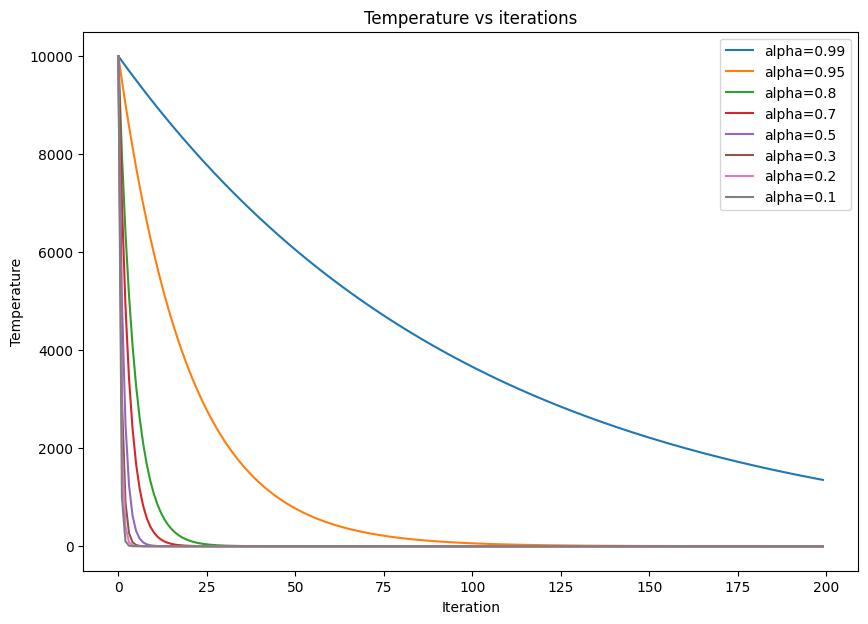

In [17]:
# Plot the temperature scheduler

alphas = [0.99, 0.95, 0.80, 0.7, 0.5, 0.3, 0.2, 0.1]
temperature = 1e4

plt.figure(figsize=(10, 7))
for alpha in alphas:
    schedule = Schedule(method="exponential", alpha= alpha, starting_temp=temperature)
    plt.plot([schedule.cool(k) for k in range(200)], label='alpha=' + str(alpha))
    plt.title('Temperature vs iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Temperature')
plt.legend()
plt.show()

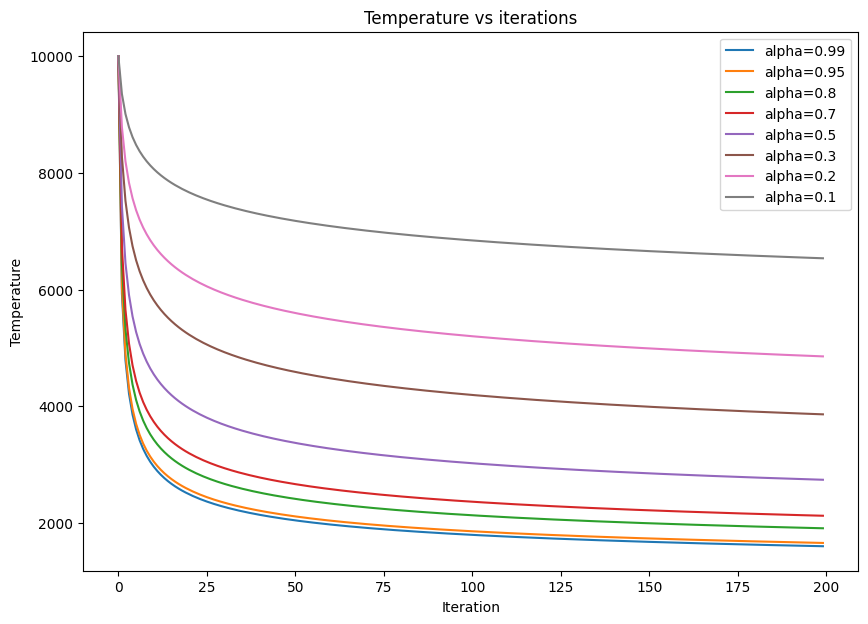

In [18]:
plt.figure(figsize=(10, 7))
for alpha in alphas:
    schedule = Schedule(method="logarithmic", alpha=alpha, starting_temp=temperature)
    plt.plot([schedule.cool(k) for k in range(200)], label='alpha=' + str(alpha))
    plt.title('Temperature vs iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Temperature')
plt.legend()
plt.show()

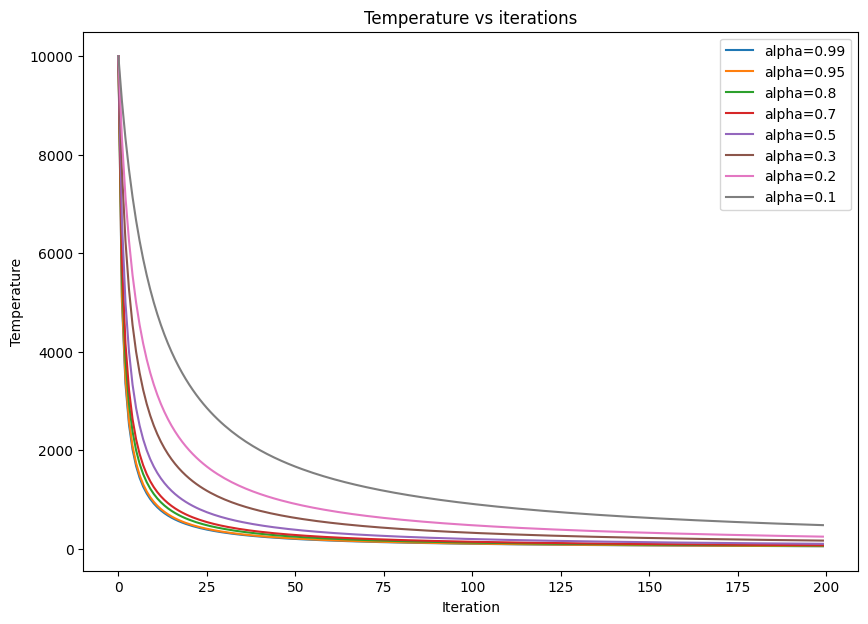

In [19]:
plt.figure(figsize=(10, 7))
for alpha in alphas:
    schedule = Schedule(method="linear", alpha= alpha, starting_temp=temperature)
    plt.plot([schedule.cool(k) for k in range(200)], label='alpha=' + str(alpha))
    plt.title('Temperature vs iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Temperature')
plt.legend()
plt.show()

### Testing the Temperature Schedule
The following tests should validate the temperature schedule function and perform a simple test of the simulated annealing function to solve a small TSP test case

In [23]:
# Failure implies that the initial path of the test case has been changed
assert(tsp.path == [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))])


schedule = Schedule(method="exponential", alpha=0.95, starting_temp=1e5)
result = simulated_annealing(tsp, schedule, stop_temp=1e-11)
print("Initial score: {}\nStarting Path: {!s}".format(tsp.evaluate(), tsp.path))
print("Final score: {}\nFinal Path: {!s}".format(result.evaluate(), result.path))
assert(tsp.path != result.path)
assert(result.evaluate() < tsp.evaluate())

Terminated with temperature T=9.6e-12
At iteration #720.
Initial score: 28.970026243745615
Starting Path: [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
Final score: 27.130286796483155
Final Path: [('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4))]


## 3.2 Run Simulated Annealing on a Larger TSP
Now we are ready to solve a TSP on a bigger problem instance by finding a shortest-path circuit through several of the US state capitals.

You can increase the `num_cities` parameter up to 30 to experiment with increasingly larger domains.  Try running the solver repeatedly -- how stable are the results?

In [114]:
capitals_subset = generate_TSP(num_cities=15, random_state=254)
capitals_subset

[['Phoenix', [179.6, 371.2]],
 ['Boston', [738.4, 190.8]],
 ['Saint Paul', [451.6, 186.0]],
 ['Little Rock', [469.2, 367.2]],
 ['Nashville', [546.4, 336.8]],
 ['Des Moines', [447.6, 246.0]],
 ['Boise', [159.6, 182.8]],
 ['Baton Rouge', [489.6, 442.0]],
 ['Harrisburg', [670.8, 244.0]],
 ['Atlanta', [585.6, 376.8]],
 ['Salt Lake City', [204.0, 243.2]],
 ['Denver', [293.6, 274.0]],
 ['Montgomery', [559.6, 404.8]],
 ['Lansing', [563.6, 216.4]],
 ['Richmond', [673.2, 293.6]]]

In [112]:
starting_city = capitals_subset[0]
starting_city

['Phoenix', [179.6, 371.2]]

Initial path value: 4031.55
Phoenix -> Boston -> Saint Paul -> Little Rock -> Nashville -> Des Moines -> Boise -> Baton Rouge -> Harrisburg -> Atlanta -> Salt Lake City -> Denver -> Montgomery -> Lansing -> Richmond


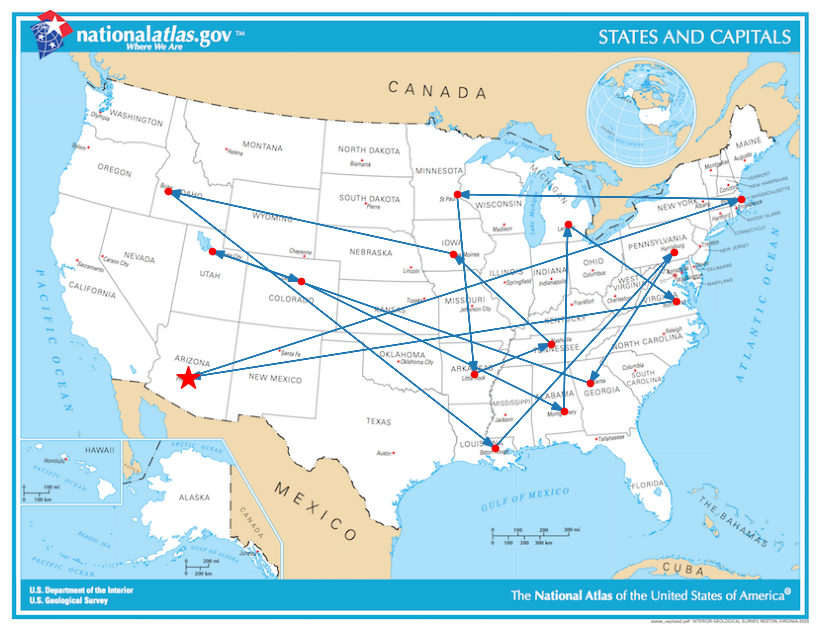

In [118]:
# Create the problem instance and plot the initial state
capitals_tsp = TravelingSalesmanProblem(capitals_subset)
starting_city = capitals_subset[0]
print("Initial path value: {:.2f}".format(capitals_tsp.evaluate()))

print(" -> ".join(i[0] for i in capitals_tsp.path))
show_path(capitals_tsp.coords, starting_city)

In [119]:
%%time
# set the decay rate and initial temperature parameters, then run simulated annealing to solve the TSP

schedule = Schedule(method="exponential", alpha=0.95, starting_temp=1e5)
result = simulated_annealing(capitals_tsp, schedule, max_iter=10_000, random_state=192)
print("Final path length: {:.2f}".format(result.evaluate()))

Terminated with temperature T=1e-05
At iteration #450.
Final path length: 3203.78
CPU times: user 493 ms, sys: 6.16 ms, total: 499 ms
Wall time: 499 ms


Phoenix -> Nashville -> Boston -> Saint Paul -> Boise -> Des Moines -> Baton Rouge -> Lansing -> Harrisburg -> Atlanta -> Little Rock -> Richmond -> Montgomery -> Denver -> Salt Lake City


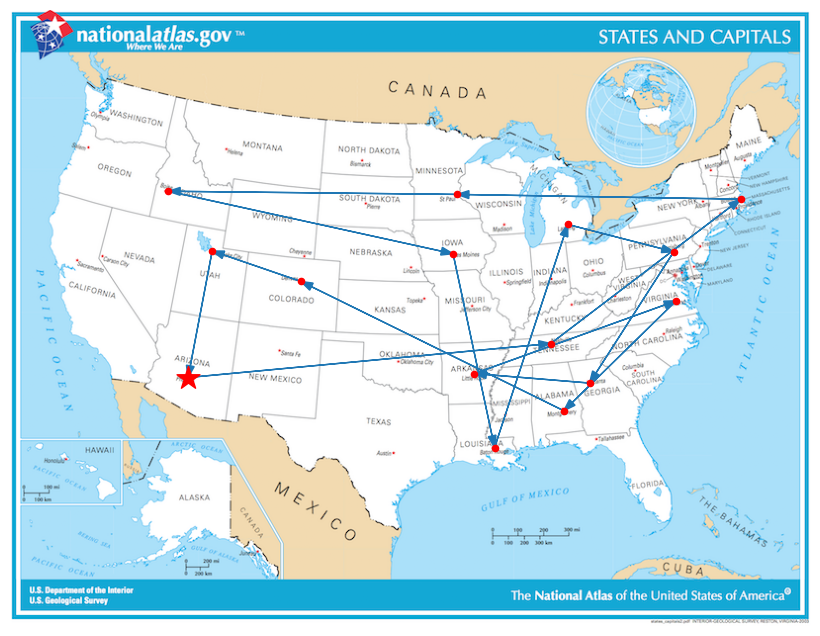

In [120]:
print(" -> ".join(i[0] for i in result.path))
show_path(result.coords, starting_city)

## 3.3 More Experiments
Here are some ideas for additional experiments with various settings and parameters once you've completed the lab.

- Change the number of cities in the final map (between 10 and 30).  How are your results affected?  Why?
- Change the alpha and temperature parameters.  How do they affect the results?
- Use a different schedule function (something other than exponential decay).  Is the algorithm still effective?
- Use a different successors function; e.g., generate successors of a state by swapping _any_ pair of cities in the path, rather than only adjacent cities.  Try defining your own successor function.  What effect does the change have?
- Use a different distance metric for get_value (e.g., we used the L2-norm (Euclidean distance), try the L1-norm (manhattan distance) or L$\infty$-norm (uniform norm)

Share and discuss your results with others in the forums!

In [121]:
schedule = Schedule(method="linear", alpha=0.95, starting_temp=1e3)

N = 20
res = []

num_cities = 15
capitals_tsp = TravelingSalesmanProblem(generate_TSP(num_cities=num_cities, random_state=254))

for i in trange(N):
    result = simulated_annealing(capitals_tsp, schedule, max_iter=1_000, stop_temp=100, verbose=False)
    res.append(result.evaluate())

stats.describe(res)

100%|██████████| 20/20 [00:00<00:00, 77.56it/s]


DescribeResult(nobs=20, minmax=(3478.267403158659, 4031.545548478337), mean=3717.1316483531436, variance=24588.0095684274, skewness=0.47117784980284455, kurtosis=-0.6886347221445228)

expo: 2812

log: 2139.2

In [122]:
schedule = Schedule(method="exponential", alpha=0.95, starting_temp=1e10)

N = 20
res = []

num_cities = 30
capitals_tsp = TravelingSalesmanProblem(generate_TSP(num_cities=num_cities, random_state=254))

for i in trange(N):
    result = simulated_annealing(capitals_tsp, schedule, verbose=False)
    res.append(result.evaluate())

stats.describe(res)

100%|██████████| 20/20 [01:06<00:00,  3.32s/it]


DescribeResult(nobs=20, minmax=(4231.003075819509, 6604.800586139623), mean=5381.2697724424615, variance=450890.7000725029, skewness=0.014523899090666367, kurtosis=-1.1053178619872646)

# 3. Hill climbing

In [123]:
# Hill Climbing algorithm
def hill_climbing(
    problem: TravelingSalesmanProblem, max_iter: float = 1e10, min_delta: float = 0
):
    iterations = 0
    current = problem  # FYI, current will always be the best path we have seen (greedy)
    delta = np.inf

    # While there is still a notable change from the last state to the next, repeat the above from the new state
    while delta > min_delta and iterations < max_iter:
        neighborhood = current.get_neighbors()
        best_neighbor_idx = np.argmin(
            [x.evaluate() for x in neighborhood]
        )  # Find the closest neighbour
        next_state = neighborhood[best_neighbor_idx]  # Move to the next state
        delta = current.evaluate() - next_state.evaluate()
        current = next_state
        iterations += 1
    return current

Initial path value: 4031.55


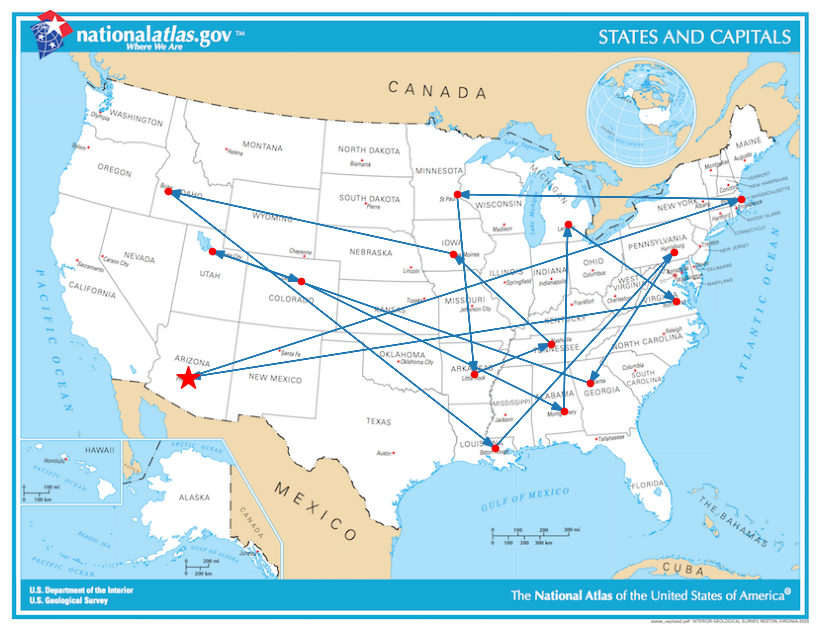

In [124]:
# Create the problem instance and plot the initial state
num_cities = 15
capitals_subset = generate_TSP(num_cities=num_cities, random_state=254)
capitals_tsp = TravelingSalesmanProblem(capitals_subset)
starting_city = capitals_subset[0]

print("Initial path value: {:.2f}".format(capitals_tsp.evaluate()))
show_path(capitals_tsp.coords, starting_city)

Final path length: 3415.30
Phoenix-> Boston-> Saint Paul-> Little Rock-> Nashville-> Des Moines-> Boise-> Baton Rouge-> Harrisburg-> Atlanta-> Salt Lake City-> Denver-> Montgomery-> Lansing-> Richmond
CPU times: user 51.1 ms, sys: 1.9 ms, total: 53 ms
Wall time: 66.7 ms


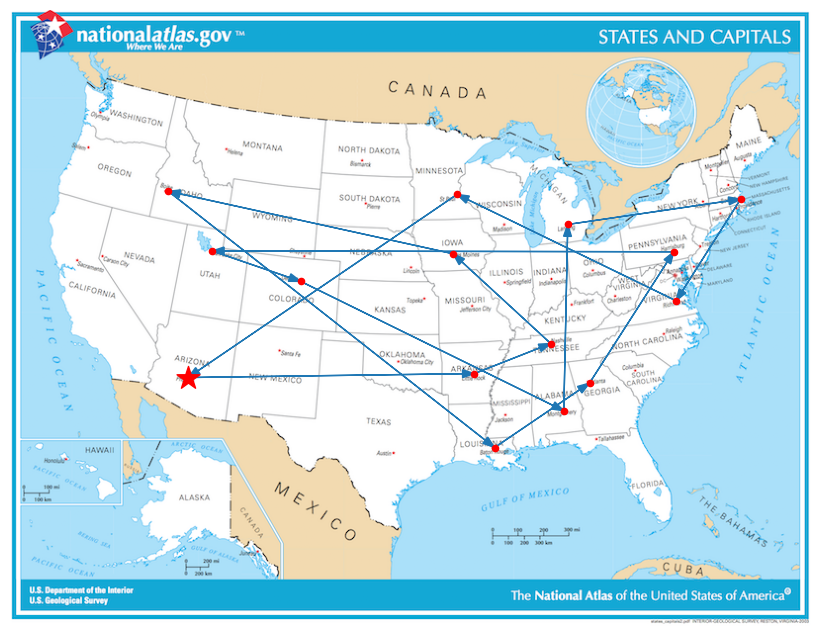

In [125]:
%%time
result = hill_climbing(capitals_tsp)
print("Final path length: {:.2f}".format(result.evaluate()))
show_path(result.coords, starting_city)
print("-> ".join(i[0] for i in capitals_tsp.path))

# 4. Tabu Search

In [36]:
# Tabu Search algorithm

def tabu_search(problem: TravelingSalesmanProblem, max_iter: int=100, tabu_tenure: int=5) -> TravelingSalesmanProblem:
    """Simple implementation of Tabu Search for TSP

    Parameters
    ----------
    problem : TravelingSalesmanProblem
        Instance of TSP
    max_iter : int, optional
        Maximum number of iterations, by default 100
    tabu_tenure : int, optional
        The number of iterations a solution should be restricted from backtracking to, by default 5

    Returns
    -------
    TravelingSalesmanProblem
        The best found TSP instance

    Notes
    -----
    This approach is essentially hill climbing but we lock some solutions away for a time dictated by ''tabu_tenure''
    """

    current = problem
    best_solution = current.copy()

    tabu_list = [hash(current)] # Holds hash of solutions
    tabu_times = [tabu_tenure] # Holds the corresponding times of solutions in tabu list

    for _ in range(max_iter):

        # Decrement all tabu timers
        for i, t in enumerate(tabu_times):
            tabu_times[i] = t-1

        # Find all neighbors not currently in the tabu list
        valid_neighbors = [x for x in current.get_neighbors() if hash(x) not in tabu_list]
        best_neighbor_idx = np.argmin([x.evaluate() for x in valid_neighbors])
        next_state = valid_neighbors[best_neighbor_idx]
        delta = current.evaluate() - next_state.evaluate()

        if delta > 0: # f(j) < f(i)
            best_solution = current.copy()

        tabu_list.append(hash(current))
        tabu_times.append(tabu_tenure)
        current = next_state

        if tabu_times[0] == 0: # Remove solution from tabu list
            tabu_list.pop(0)
            tabu_times.pop(0)

    return best_solution

Initial path value: 4031.55


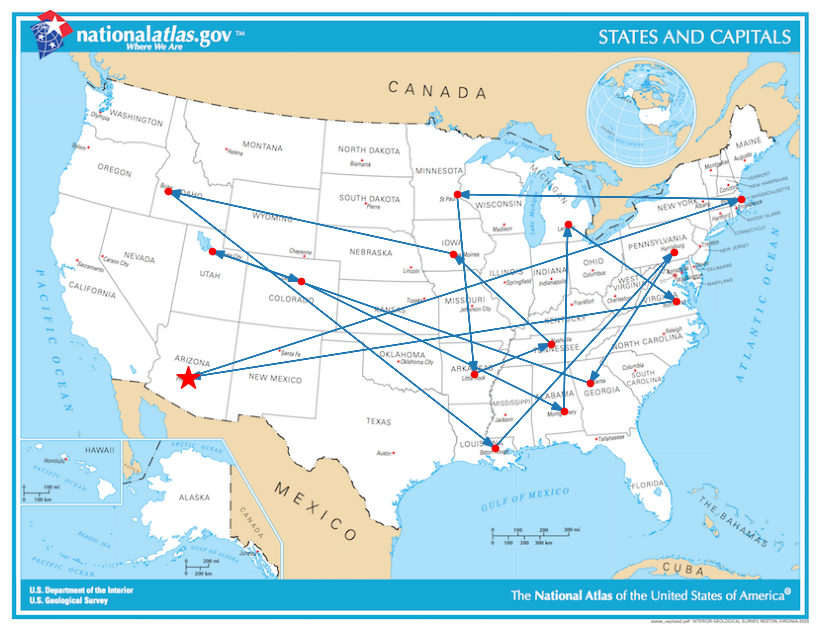

In [126]:
# Create the problem instance and plot the initial state
num_cities = 15
capitals_subset = generate_TSP(num_cities=num_cities, random_state=254)
capitals_tsp = TravelingSalesmanProblem(capitals_subset)
starting_city = capitals_subset[0]

print("Initial path value: {:.2f}".format(capitals_tsp.evaluate()))
show_path(capitals_tsp.coords, starting_city)

Final path length: 3029.17
Phoenix-> Boston-> Saint Paul-> Little Rock-> Nashville-> Des Moines-> Boise-> Baton Rouge-> Harrisburg-> Atlanta-> Salt Lake City-> Denver-> Montgomery-> Lansing-> Richmond
CPU times: user 669 ms, sys: 0 ns, total: 669 ms
Wall time: 693 ms


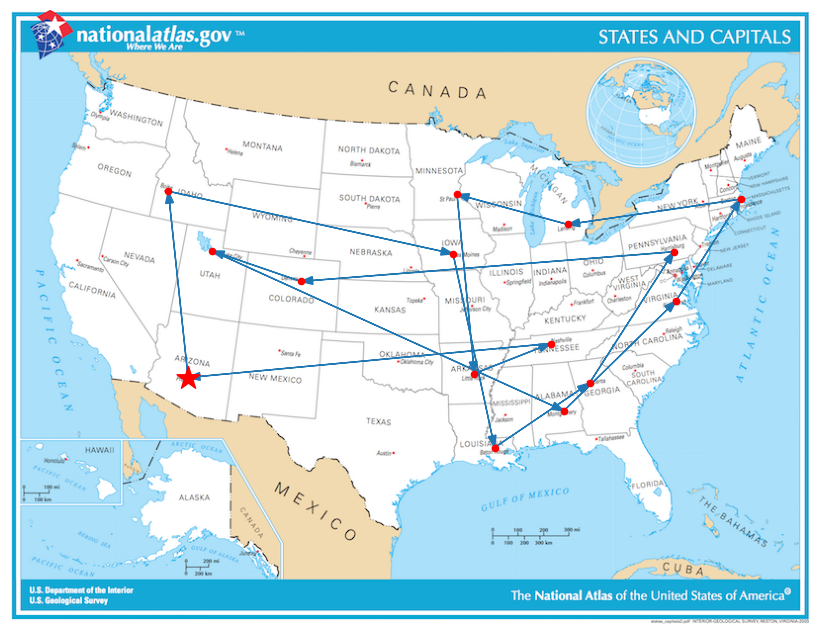

In [127]:
%%time
result = tabu_search(capitals_tsp, max_iter=250, tabu_tenure=20)
print("Final path length: {:.2f}".format(result.evaluate()))

show_path(result.coords, starting_city)
print("-> ".join(i[0] for i in capitals_tsp.path))

# 5. Genetic Algorithm

In [42]:
class GeneticTSP():
    """Implements TSP using a genetic algorithm as the optimizer. This implementation is a little
    more dependent on the problem than the other methods shown, but each of the operators can be
    removed and used for other problems provided a similar genotype is used.

    Parameters
    ----------
    cities : list
        A list of cities specified by a tuple containing the name and the x, y
        location of the city on a grid. e.g., ("Atlanta", (585.6, 376.8))

    random_state : integer
        A random seed for the self-contained random number generator. Allows for results to be
        reproducible across runs.

    Attributes
    ----------
    phenotype : list
        Merely stores the cities as our original solution representation. This is used to compute the
        fitness and to produce a final solution at the end by indexing the phenotype by the genotype.

    num_cities : int
        Stores how many cities we have, and thus the dimensions of each solution (see generate_population).

    rand_gen : np.random.default_rng
        Random number generator, seeded with random_state.

    population : list
        Stores potential solutions in a list. This data structure is what all other operations are performed on.

    fitness : list
        Stores the fitness of each solution in the current population. Not really necessary to store this, but can
        be retrieved at the end of optimization to compare the best found solution with other members in the population.

    best_solution : list
        A genotype of the best solution currently found.

    best_fitness : float
        Corresponding fitness for the best found solution. Used to determine whether or not to replace best_solution each iteration.
    """
    def __init__(self, cities, random_state=None):
        self.phenotype = cities
        self.num_cities = len(cities)
        self.rand_gen = np.random.default_rng(random_state)

        self.population = []
        self.fitness = []

        self.best_solution = None
        self.best_fitness = np.NINF

    def generate_population(self, pop_size):
        """
        Here we are generating the population by starting with a list with unique elements [1...num_cities], and
        then perturbing this list to produce pop_size number of solutions.
        """
        for i in range(pop_size):
            solution = self.rand_gen.choice(range(self.num_cities), size=(self.num_cities, ), replace=False)
            self.population.append(solution)

        self.population = np.array(self.population)

    def compute_fitness(self):
        """
        All we're really doing here is just converted the genotype back into the phenotype,
        calling the evaluate method from the TSP class, and then just sticking that it in our fitness array.
        Keep in mind we have to invert the cost here otherwise high cost paths will have a higher
        probability of being chosen in selection.
        """
        fitness = []
        for _, p in enumerate(self.population):
            solution = TravelingSalesmanProblem(np.array(self.phenotype, dtype="object")[p])
            fitness.append(1/(solution.evaluate()))


        self.fitness = fitness

    def selection(self, num_mating=10, replacement=False):
        """
        Implements roulette selection. Solutions with higher fitness are more likely
            to be chosen, and can be considered as taking up "more area" on a roulette wheel.
        """
        selected = []
        total_fit = np.sum(self.fitness)

        while (len(selected) != num_mating):
            choice = self.rand_gen.integers(0, len(self.fitness))

            if not replacement and choice in selected:
                pass

            if self.fitness[choice]/total_fit < self.rand_gen.uniform(0, 1):
                selected.append(choice)

        return selected

    def order_crossover(self, parent1, parent2, crossover_rate=0.9):
        """
        Performs order crossover. First starts by selecting two splitting points. The alleles
            contained in between these points are copied down to respective children 1 and 2.
            All other alleles outside of the split are taken in order from the second split to the first split,
            looping back around whenever necessary to form a sequence. Child 1 gets the sequence of parent 2
            and vice versa with the section contained in the split of parent 1/parent 2. If there are any duplicate
            allele values in the sequence, these are dropped.
        """
        if self.rand_gen.uniform() < crossover_rate:
            split1 = self.rand_gen.integers(0, len(parent1)-2)
            split2 = self.rand_gen.integers(split1+1, len(parent1))

            sequence_for_p1 = np.concatenate((parent2[split2:], parent2[:split1], parent2[split1:split2]))
            sequence_for_p1 = np.delete(sequence_for_p1, np.isin(sequence_for_p1, parent1[split1:split2]))

            sequence_for_p2 = np.concatenate((parent1[split2:], parent1[:split1], parent1[split1:split2]))
            sequence_for_p2 = np.delete(sequence_for_p2, np.isin(sequence_for_p2, parent2[split1:split2]))

            child1 = copy.deepcopy(parent1)
            child2 = copy.deepcopy(parent2)

            idx = split2
            for _, (sp1, sp2) in enumerate(zip(sequence_for_p1, sequence_for_p2)):
                if idx > len(child1)-1:
                    idx = 0

                child1[idx] = sp1
                child2[idx] = sp2

                idx += 1
            return (child1, child2)

        else:
            return (parent1, parent2)

    def mutation(self, solution, mutation_rate=0.03):
        """
        Performs mutation by swapping 2 cities somewhere in the
           solution at random.
        """
        modified = copy.deepcopy(solution)

        for i, v in enumerate(modified):
            if self.rand_gen.uniform() < mutation_rate:

                # Find which city to place at the current position
                change_to = self.rand_gen.integers(0, len(solution))

                # To avoid duplicates, find where we need to make a swap
                swap = np.where(modified==change_to)[0][0]

                modified[i] = change_to
                modified[swap] = v

        return modified

    def optimize(self, max_iter, pop_size, num_mating, crossover_rate=0.9, mutation_rate=0.03):
        """
        Performs the main loop of the algorithm. We
        generate population->calculate fitness->selection->crossover->mutation.
        This current version just simply replaces the parents with the children.
        A good exercise would be to try and change up the operators or include
        replacement with a deletion strategy.

        See Also
        ---
        Paper on various strategies for TSP with GA:
        https://www.hindawi.com/journals/cin/2017/7430125/
        """

        self.generate_population(pop_size)
        for _ in trange(max_iter):

            # Compute fitness
            self.compute_fitness()
            best = np.argmax(self.fitness)

            if self.fitness[best] > self.best_fitness:
                self.best_fitness = copy.deepcopy(self.fitness[best])
                self.best_solution = copy.deepcopy(self.population[best])

            # Perform selection
            select_idx = self.selection(num_mating)
            select_sols = self.population[select_idx]

            # Perform crossover
            for i in range(num_mating//2):
                children = self.order_crossover(
                    select_sols[i], select_sols[num_mating//2+i], crossover_rate
                    )

                # Replace parents with children
                self.population[select_idx[i]] = children[0]
                self.population[select_idx[num_mating//2+i]] = children[1]

            for i, v in enumerate(self.population):
                mutated = self.mutation(v, mutation_rate)
            #    self.population[i] = mutated

            for i in range(pop_size):
                self.population[i] = self.mutation(self.population[i], mutation_rate)

        # Find the best solution in the final population
        best_sol_idx = np.argmax(self.fitness)
        best_sol = self.population[best_sol_idx]

        # Convert genotype to phenotype
        best_sol = TravelingSalesmanProblem(np.array(self.phenotype, dtype="object")[self.best_solution])

        return best_sol

## Testing GA

In [130]:
capitals_subset = generate_TSP(num_cities=num_cities, random_state=254)
capitals_subset

[['Phoenix', [179.6, 371.2]],
 ['Boston', [738.4, 190.8]],
 ['Saint Paul', [451.6, 186.0]],
 ['Little Rock', [469.2, 367.2]],
 ['Nashville', [546.4, 336.8]],
 ['Des Moines', [447.6, 246.0]],
 ['Boise', [159.6, 182.8]],
 ['Baton Rouge', [489.6, 442.0]],
 ['Harrisburg', [670.8, 244.0]],
 ['Atlanta', [585.6, 376.8]],
 ['Salt Lake City', [204.0, 243.2]],
 ['Denver', [293.6, 274.0]],
 ['Montgomery', [559.6, 404.8]],
 ['Lansing', [563.6, 216.4]],
 ['Richmond', [673.2, 293.6]]]

Initial path value: 4031.55


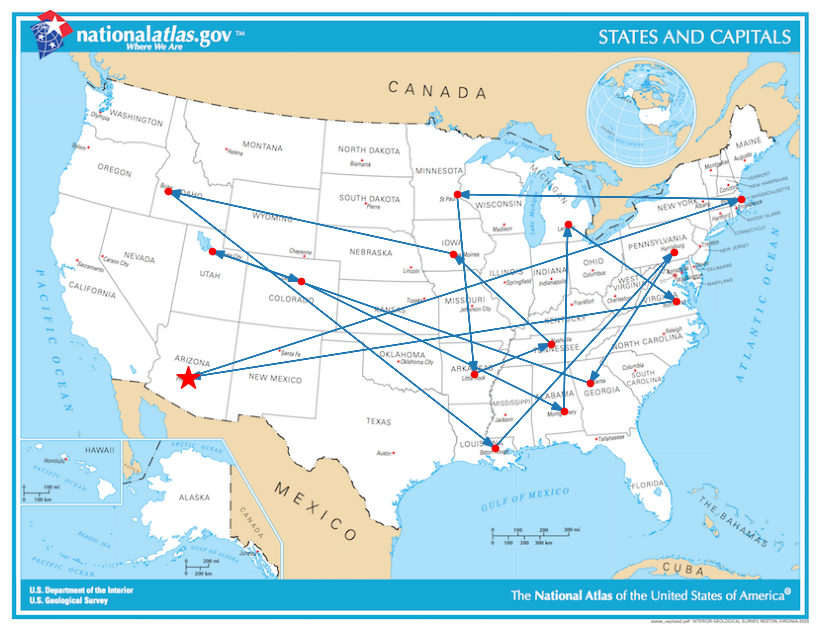

In [131]:
# Create the problem instance and plot the initial state
capitals_tsp = TravelingSalesmanProblem(capitals_subset)
starting_city = capitals_subset[0]
print("Initial path value: {:.2f}".format(capitals_tsp.evaluate()))
show_path(capitals_tsp.coords, starting_city)

100%|██████████| 1000/1000 [00:09<00:00, 107.73it/s]


Final path length: 2183.72
Montgomery -> Richmond -> Harrisburg -> Boston -> Des Moines -> Lansing -> Denver -> Phoenix -> Boise -> Salt Lake City -> Saint Paul -> Atlanta -> Nashville -> Little Rock -> Baton Rouge
CPU times: user 9.05 s, sys: 188 ms, total: 9.24 s
Wall time: 9.34 s


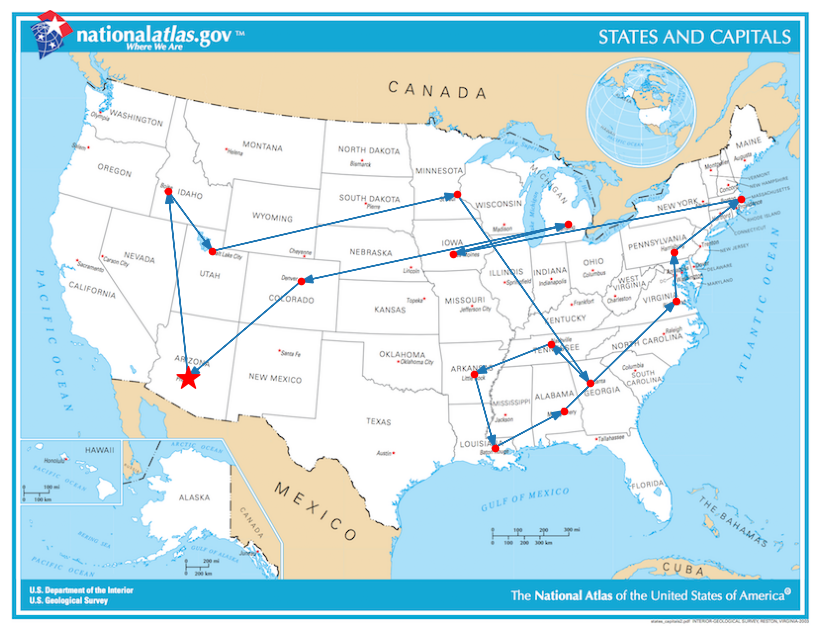

In [132]:
%%time
ga_inst = GeneticTSP(capitals_subset, random_state=506)
result = ga_inst.optimize(max_iter=1000, pop_size=30, num_mating=10, mutation_rate=0.07)
print("Final path length: {:.2f}".format(result.evaluate()))

show_path(result.coords, starting_city)
print(" -> ".join(i[0] for i in result.path))

So for this paticular problem instance of TSP (fixed with seed=254), we find that GA performs the best with the parameters we have chosen, followed by SA, and then TS and Hill Climbing.
For future study and practice, try to change different parameters, implement different cooling schedules, GA operators, frequency/recency measures for TS, etc. to further improve the shown techniques.